In [3]:
import numpy as np
import scipy.io as sio
import scipy.interpolate as interp
import matplotlib.pyplot as plt

Dataloading and signal processing for DGEN 380 Turbofan datast https://zenodo.org/records/13860307

Code by Fadi Karkafi, some comments made for better understanding by Douw Marx

In [4]:
class SP:
    def __init__(self, fs, angular_domain=True):
        self.fs = fs # can be samples per second or samples per rev
        self.angular_domain = angular_domain
        self.speed = None
        self.x = None
        self.theta = None
        if self.angular_domain: 
            self.fs = fs  # Fs is treated as SmpPerRev if in angular domain # Samples per revolution

    def set_data(self, x, speed=None):
        self.x = x
        if not self.angular_domain and speed is not None:
            self.speed = speed
            self.compute_theta_time_domain()
            self.resample_to_angular_domain()
        self.compute_theta_angular_domain()
    
    def compute_theta_time_domain(self):
        # Compute theta as the cumulative sum of the speed in time domain
        self.theta = 2 * np.pi * np.cumsum(self.speed) / self.fs
    
    def compute_theta_angular_domain(self):
        smp_per_rev = int(self.fs / np.min(self.speed)) if self.speed is not None else self.fs
        resolution = 1 / self.fs
        self.theta = np.arange(0, resolution * len(self.x), resolution)
        self.theta = self.theta[:len(self.x)]
    
    def resample_to_angular_domain(self):
        smp_per_rev = int(self.fs / np.min(self.speed))
        self.x = interp.interp1d(self.theta, self.x, kind='linear', fill_value='extrapolate')(np.arange(np.min(self.theta), np.max(self.theta), 1 / smp_per_rev))
        self.fs = smp_per_rev  # (Now samples per rev) Update fs to be treated as SmpPerRev in angular domain
    
    def forward(self, order): # order: Events per revolution # 14: This is related to
        # Find the mean of the demodulated signal with respect to the defined order
        demodulated_signal = self.x * np.exp(-1j * order * self.theta) # Theta is always linearly spaced here
                                                                       # Demodulate, shift to dc part, then mean
        mean_value = np.abs(np.mean(demodulated_signal)) # Abs because it is complex valued
        return mean_value

    def plot_speed(self):
        if self.speed is not None:
            plt.figure()
            plt.plot(np.arange(len(self.speed)) / self.fs, self.speed)
            plt.xlabel('Time (s)')
            plt.ylabel('Speed (RPS)')
            plt.title('Engine Speed over Time')
            plt.show()

    def plot_order_spectrum(self, residual_Y):
        plt.figure()
        plt.plot(np.abs(residual_Y))
        plt.xlabel('Order')
        plt.ylabel('Amplitude')
        plt.title('Order Spectrum')
        plt.show()

In [5]:


def main_angular_domain():
    """
For nomal stationary case, but using the angular approach
Signal is a function of theta x(theta). 
"""
    mean_values_angular = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_2_normal_1.mat" # statationary normal
    performance_path = "Desir_II_config_2_perfo_normal_1.mat" # Assocaiated condition/speed (tehcnicall stationary)
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)

    plt.figure()
    plt.plot(np.arange(len(speed_rps)) / fs, speed_rps)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (RPS)')
    plt.title('Engine Speed over Time')
    plt.show()

    theta = 2 * np.pi * np.cumsum(speed_rps) / fs
    
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        theta_segment = theta[i * segment_length:(i + 1) * segment_length]
        smp_per_rev = int(fs / np.min(speed_segment))
        x_resampled = interp.interp1d(theta_segment, x_segment, kind='linear', fill_value='extrapolate')(np.arange(np.min(theta_segment), np.max(theta_segment), 1 / smp_per_rev))
        
        processor = SP(smp_per_rev, angular_domain=True) #
        
        processor.set_data(x_resampled)
        
        order = 14
        mean_value = processor.forward(order)
        mean_values_angular.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Angular Domain
    plt.figure()
    plt.plot(mean_values_angular, label='Angular Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Angular Domain Segments')
    plt.legend()
    plt.show()


def main_time_domain():
    """
For nomal stationary case, but using the non-angular aproach
Signal is a function of t x(t). 
"""
    mean_values_time = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_2_normal_1.mat"
    performance_path = "Desir_II_config_2_perfo_normal_1.mat"
    fs = 40960

    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)
    
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        processor = SP(fs, angular_domain=False)
        
        processor.set_data(x_segment, speed_segment)
        
        order = 14
        mean_value = processor.forward(order)
        mean_values_time.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Time Domain
    plt.figure()
    plt.plot(mean_values_time, label='Time Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Time Domain Segments')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    print("Processing Angular Domain:")
    main_angular_domain()
    print("\nProcessing Time Domain:")
    main_time_domain()

Processing Angular Domain:


FileNotFoundError: [Errno 2] No such file or directory: 'Desir_II_configuration_2_normal_1.mat'

In [8]:
def main_angular_domain():
    """
    Non-staitonary normal because 2 and not 1
    """
    mean_values_angular = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_2_normal_2.mat"
    performance_path = "Desir_II_config_2_perfo_normal_2.mat"
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    # Convert speed from RPM to RPS
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)

    plt.figure()
    plt.plot(np.arange(len(speed_rps)) / fs, speed_rps)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (RPS)')
    plt.title('Engine Speed over Time')
    plt.show()

    theta = 2 * np.pi * np.cumsum(speed_rps) / fs
    
    # Segment the data
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    # Iterate through each segment
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        # Segment the theta
        theta_segment = theta[i * segment_length:(i + 1) * segment_length]
        smp_per_rev = int(fs / np.min(speed_segment))
        x_resampled = interp.interp1d(theta_segment, x_segment, kind='linear', fill_value='extrapolate')(np.arange(np.min(theta_segment), np.max(theta_segment), 1 / smp_per_rev))
        
        # Create an instance of SP (Signal Processing)
        processor = SP(smp_per_rev, angular_domain=True) # Check this flag is true now but False in the next
        
        # Set data in the processor
        processor.set_data(x_resampled)
        
        # Compute forward for order component (order = 14)
        order = 14
        mean_value = processor.forward(order)
        mean_values_angular.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Angular Domain
    plt.figure()
    plt.plot(mean_values_angular, label='Angular Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Angular Domain Segments')
    plt.legend()
    plt.show()


def main_time_domain():
    mean_values_time = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_2_normal_2.mat"
    performance_path = "Desir_II_config_2_perfo_normal_2.mat"
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    # Convert speed from RPM to RPS
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)
    
    # Segment the data
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    # Iterate through each segment
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        # Create an instance of SP (Signal Processing)
        processor = SP(fs, angular_domain=False)
        
        # Set data in the processor
        processor.set_data(x_segment, speed_segment)
        
        # Compute forward for order component (order = 14)
        order = 14
        mean_value = processor.forward(order)
        mean_values_time.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Time Domain
    plt.figure()
    plt.plot(mean_values_time, label='Time Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Time Domain Segments')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    print("Processing Angular Domain:")
    main_angular_domain()
    print("\nProcessing Time Domain:")
    main_time_domain()

Processing Angular Domain:


TypeError: main_angular_domain() missing 2 required positional arguments: 'data_path' and 'performance_path'

Processing Angular Domain:


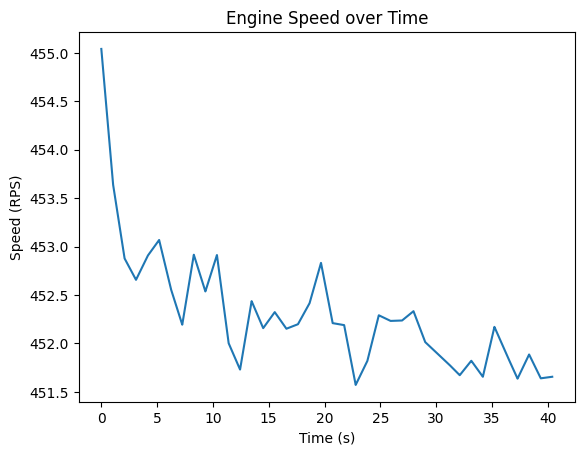

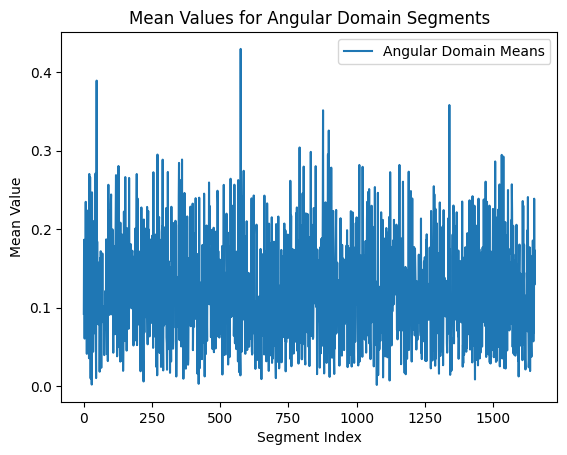


Processing Time Domain:


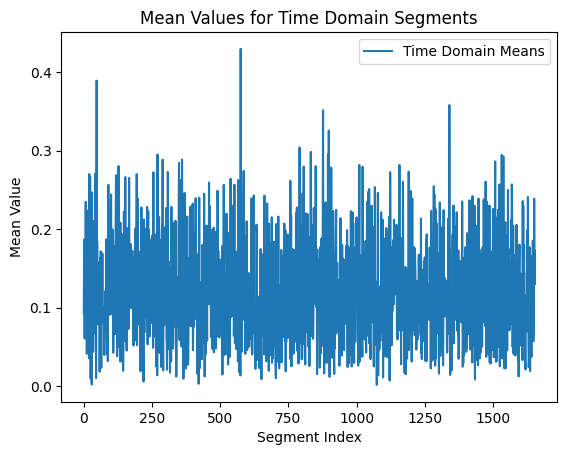

In [5]:
def main_angular_domain():
    mean_values_angular = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_4_faulty_1.mat"
    performance_path = "DESIR_II_config_4_perfo_faulty_1.mat"
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    # Convert speed from RPM to RPS
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)

    plt.figure()
    plt.plot(np.arange(len(speed_rps)) / fs, speed_rps)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (RPS)')
    plt.title('Engine Speed over Time')
    plt.show()

    theta = 2 * np.pi * np.cumsum(speed_rps) / fs
    
    # Segment the data
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    # Iterate through each segment
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        # Segment the theta
        theta_segment = theta[i * segment_length:(i + 1) * segment_length]
        smp_per_rev = int(fs / np.min(speed_segment))
        x_resampled = interp.interp1d(theta_segment, x_segment, kind='linear', fill_value='extrapolate')(np.arange(np.min(theta_segment), np.max(theta_segment), 1 / smp_per_rev))
        
        # Create an instance of SP (Signal Processing)
        processor = SP(smp_per_rev, angular_domain=True)
        
        # Set data in the processor
        processor.set_data(x_resampled)
        
        # Compute forward for order component (order = 14)
        order = 14
        mean_value = processor.forward(order)
        mean_values_angular.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Angular Domain
    plt.figure()
    plt.plot(mean_values_angular, label='Angular Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Angular Domain Segments')
    plt.legend()
    plt.show()


def main_time_domain():
    mean_values_time = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_4_faulty_1.mat"
    performance_path = "DESIR_II_config_4_perfo_faulty_1.mat"
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    # Convert speed from RPM to RPS
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)
    
    # Segment the data
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    # Iterate through each segment
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        # Create an instance of SP (Signal Processing)
        processor = SP(fs, angular_domain=False)
        
        # Set data in the processor
        processor.set_data(x_segment, speed_segment)
        
        # Compute forward for order component (order = 14)
        order = 14
        mean_value = processor.forward(order)
        mean_values_time.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Time Domain
    plt.figure()
    plt.plot(mean_values_time, label='Time Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Time Domain Segments')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    print("Processing Angular Domain:")
    main_angular_domain()
    print("\nProcessing Time Domain:")
    main_time_domain()

Processing Angular Domain:


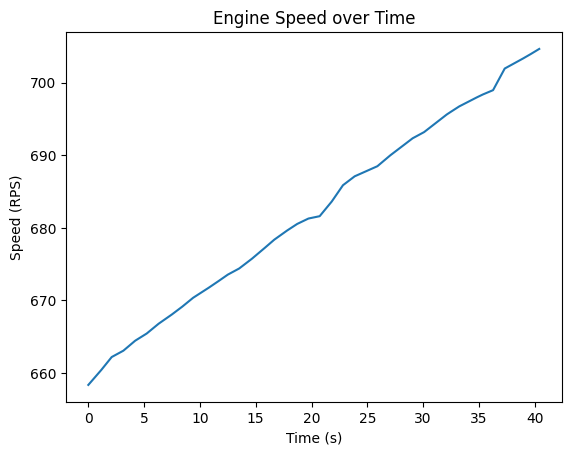

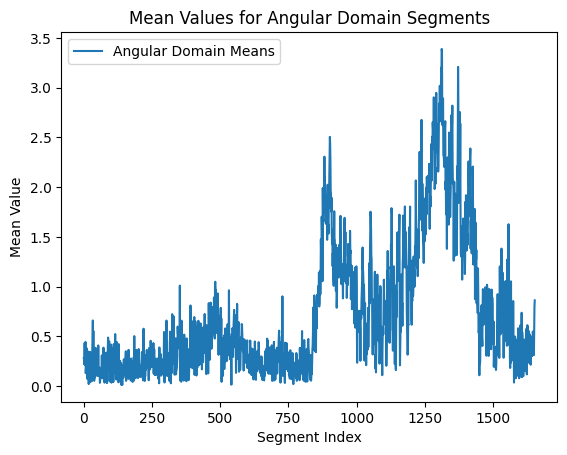


Processing Time Domain:


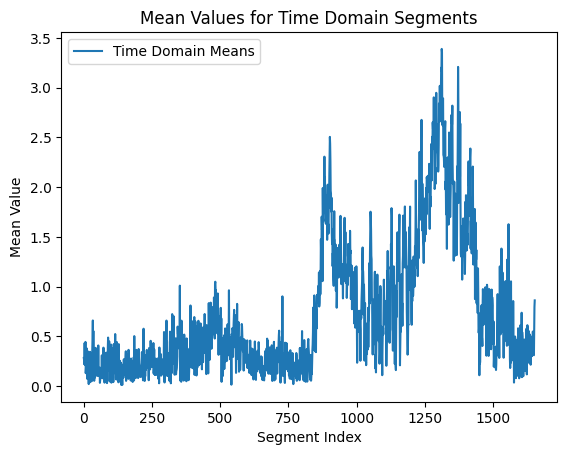

In [6]:
def main_angular_domain():
    mean_values_angular = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_4_faulty_2.mat"
    performance_path = "DESIR_II_config_4_perfo_faulty_2.mat"
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    # Convert speed from RPM to RPS
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)

    plt.figure()
    plt.plot(np.arange(len(speed_rps)) / fs, speed_rps)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (RPS)')
    plt.title('Engine Speed over Time')
    plt.show()

    theta = 2 * np.pi * np.cumsum(speed_rps) / fs
    
    # Segment the data
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    # Iterate through each segment
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        # Segment the theta
        theta_segment = theta[i * segment_length:(i + 1) * segment_length]
        smp_per_rev = int(fs / np.min(speed_segment))
        x_resampled = interp.interp1d(theta_segment, x_segment, kind='linear', fill_value='extrapolate')(np.arange(np.min(theta_segment), np.max(theta_segment), 1 / smp_per_rev))
        
        # Create an instance of SP (Signal Processing)
        processor = SP(smp_per_rev, angular_domain=True)
        
        # Set data in the processor
        processor.set_data(x_resampled)
        
        # Compute forward for order component (order = 14)
        order = 14
        mean_value = processor.forward(order)
        mean_values_angular.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Angular Domain
    plt.figure()
    plt.plot(mean_values_angular, label='Angular Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Angular Domain Segments')
    plt.legend()
    plt.show()


def main_time_domain():
    mean_values_time = []
    # File paths for the normal case
    data_path = "Desir_II_configuration_4_faulty_2.mat"
    performance_path = "DESIR_II_config_4_perfo_faulty_2.mat"
    fs = 40960

    # Load data
    data = sio.loadmat(data_path)
    performance = sio.loadmat(performance_path)
    
    x = data['mic5'].astype(float).flatten()
    t_speed = performance['t'].flatten()
    speed_rpm = performance['NH'].flatten()
    
    # Convert speed from RPM to RPS
    speed_rps = speed_rpm / 60.0
    t_signal = np.linspace(t_speed[0], t_speed[-1], len(x))
    interpolator = interp.interp1d(t_speed, speed_rps, kind='linear', fill_value='extrapolate')
    speed_rps = interpolator(t_signal)
    
    # Segment the data
    segment_length = 1000
    num_segments = len(x) // segment_length
    
    # Iterate through each segment
    for i in range(num_segments):
        x_segment = x[i * segment_length:(i + 1) * segment_length]
        speed_segment = speed_rps[i * segment_length:(i + 1) * segment_length]
        
        # Create an instance of SP (Signal Processing)
        processor = SP(fs, angular_domain=False)
        
        # Set data in the processor
        processor.set_data(x_segment, speed_segment)
        
        # Compute forward for order component (order = 14)
        order = 14
        mean_value = processor.forward(order)
        mean_values_time.append(mean_value)

        # # Plot engine speed
        # processor.plot_speed()

        # # Compute and plot order spectrum
        # residual_Y = np.fft.fft(processor.x)
        # processor.plot_order_spectrum(residual_Y)

    # Plot mean values for Time Domain
    plt.figure()
    plt.plot(mean_values_time, label='Time Domain Means')
    plt.xlabel('Segment Index')
    plt.ylabel('Mean Value')
    plt.title('Mean Values for Time Domain Segments')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    print("Processing Angular Domain:")
    main_angular_domain()
    print("\nProcessing Time Domain:")
    main_time_domain()